## Attention Machenism

### 心理学
* 动物需要在复杂环境下有效关注值得注意的点
* 心理学框架：人类根据随意线索和不随意线索选择注意点
    * 看到一个红色杯子：不随意搜索
    * 想读书：随意搜索(其实是active，随从自己的想法)

### 注意力机制
* 卷积、全连接、池化层都只考虑不随意搜索
* 注意力机制则显示的考虑随意搜索
    * 随意搜索被称为查询(query)
    * 每个输入是一个值(value)，和不随意搜索(key)的对
    * 通过注意力池化层来有偏向性的选择某些输入

![attention machenism](./imgs/attention_machenism.png)

### 非参注意力池化层
* 给定数据$(x_i, y_i), i = 1, ..., n$
* 平均池化是最简单的方案: $f(x) = \frac{1}{n}\Sigma_i y_i$
* 更好的方案是Nadaraya-Watson核回归(1960 or so)
$$
f(x) = \Sigma_{i = 1}^n \frac{K(x - x_i)}{\Sigma_{j = 1}^n K(x - x_j)}y_i
$$
其中x是query，x_i是key，y_i是value

### Nadaraya-Watson核回归
* 使用高斯核$K(u) = \frac{1}{\sqrt{2 \pi}} exp(-\frac{u^2}{2})$
* 则
$$
f(x) = \Sigma_{i = 1}^n \frac{exp(-\frac{1}{2} (x - x_i)^2)}{\Sigma_{j = 1}^n exp (-\frac{1}{1} (x - x_j)^2)} y_i\\
= \Sigma_{i = 1}^n softmax((-\frac{1}{2} (x - x_i)^2) y_i)
$$

### 参数化的注意力机制
* 在此前基础上引入可以学习的w
$$
f(x) = \Sigma_{i = 1}^n softmax(-\frac{1}{2}( (x - x_i)w)^2)y_i
$$

### 代码

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

In [2]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);


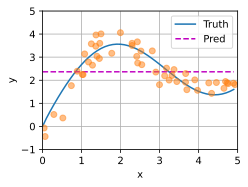

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

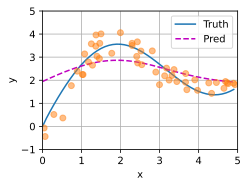

In [5]:

X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

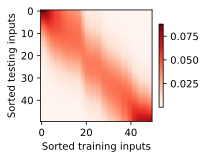

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [7]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [8]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [9]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [10]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))


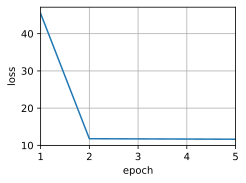

In [11]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

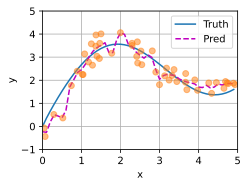

In [12]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

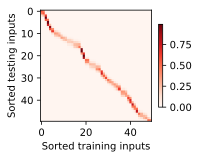

In [13]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 注意力分数
* 回顾：
$$
f(x) = \Sigma_i \alpha(x, x_i)y_i = \Sigma_{i = 1}^n softmax(-\frac{1}{2} (x - x_i)^2 )y_i
$$
其中：
* $\alpha$是注意力权重
* $-\frac{1}{2} (x - x_i)^2$是注意力分数

![attention score](./imgs/attention_fraction.png)

### 拓展到高维度
* 假设query $q \in R^q$, m对kay-value($k_1, v_1$), ..., 这里的$k_i \in R^k, v_i \in R$
* 注意力池化层

$$
f(q, (k_1, v_1), ..., (k_m, v_m)) = \Sigma_{i = 1}^m \alpha (q, k_i), v_i \in R^v
$$


$$
\alpha(q, k_i) = softmax(a(q, k_i)这个就是注意力分数) = \frac{exp(a(q, k_i))}{\Sigma_{j = 1}^m exp(a(q, k_j))} \in R
$$


### Additive Attention
* 可学参数：
$$
W_k \in R^{h*k}, W_q \in R^{h*q}, v \in R^h\\
a(k, q) = v^T tanh(W_k k + W_q q)
$$
* 等价于将key和value合并起来之后放入一个隐藏层为h，输出大小为1的单隐藏层MLP

### Scaled Dot-Product Attention
* 如果query和key都是同样长度$q, k_i \in R^d$，那么可以
$$
a(q, k_i) = <q, k_i> / \sqrt{d}
$$

* 向量化版本
    * $Q \in R^{n * d}, K \in R^{m * d}, V \in R^{n*m}$
    * 注意力分数：$ a(Q, K) = QK^T / \sqrt{d} \in R^{n * m} $
    * 注意力池化：$f = softmax(a(Q, K))V \in R^{n*v} $


summary
* 注意力分数是query和key的相似度，注意力权重是分数softmax结果
* 两种常见的分数运算
    * 一个是将query和key合并起来进入一个单输出单隐藏层的MLP
    * 直接将query和key做内积


### 代码


In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 遮蔽masked softmax操作

def masked_softmax(X, valid_lens):
    '''通过最后一个轴上屏蔽元素来执行softmax操作'''
    if valid_lens is None:
        return nn.functional.softmax(X, dim=1)
    
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(
            X.reshape(-1, shape[-1]), 
            valid_lens, value=-1e6
        )
        return nn.functional.softmax(X.reshape(shape), dim=-1)
            

# 试一下
(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])), 
 masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]])))

(tensor([[[0.5697, 0.4303, 0.0000, 0.0000],
          [0.5287, 0.4713, 0.0000, 0.0000]],
 
         [[0.2103, 0.4498, 0.3399, 0.0000],
          [0.4010, 0.2857, 0.3134, 0.0000]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.3238, 0.4125, 0.2637, 0.0000]],
 
         [[0.5196, 0.4804, 0.0000, 0.0000],
          [0.3535, 0.2030, 0.1390, 0.3044]]]))

In [10]:
# 可加注意力

class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, 
                 num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # queries.unsqueeze(2) 使得 queries 的形状从 (batch_size, num_queries, num_hiddens) 变为 (batch_size, num_queries, 1, num_hiddens)。
        # keys.unsqueeze(1) 使得 keys 的形状从 (batch_size, num_keys, num_hiddens) 变为 (batch_size, 1, num_keys, num_hiddens)。
        # 这样 queries + keys 会得到形状为 (batch_size, num_queries, num_keys, num_hiddens) 的张量，它包含了所有 query 和 key 对的特征。
        
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1) # 去掉最后的维度
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
		# bmm: batch mm
        
        
# 演示

queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

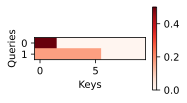

In [11]:
# 注意力权重
d2l.show_heatmaps(
	attention.attention_weights.reshape((1, 1, 2, 10)),
    xlabel='Keys', ylabel='Queries')

In [13]:
# 缩放点积注意力

class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [14]:
# 演示
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

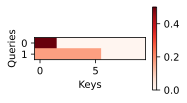

In [15]:
# 均匀的注意力权重

d2l.show_heatmaps(
	attention.attention_weights.reshape((1, 1, 2, 10)),
    xlabel='Keys', ylabel='Queries'
)

## 使用注意力机制的seq2seq

### 动机

* 机器翻译中，每个生成的词肯呢各相关于源句子中不同的词
* seq2seq模型不能对比直接建模



### 加入注意力

![seq2seq with attention](./imgs/seq2seq_with_attention.png)

* 编码器对每次词的输出作为key和value(它们是一样的)
* 解码器RNN对上一个词的输出是query
* 注意力的输出和下一个词的词嵌入合并进入



In [17]:
# Bahdanau注意力

import torch
from torch import nn
from d2l import torch as d2l

In [18]:
# 带有注意力机制的解码器基本接口

class AttentionDecoder(d2l.Decoder):
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
        
    @property
    def attention_weights(self):
        raise NotImplementedError

In [29]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, 
                 num_layers, dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, 
                          num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(
                self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [
            enc_outputs, hidden_state, enc_valid_lens
        ]

In [30]:
# 测试
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.019, 9823.9 tokens/sec on cpu


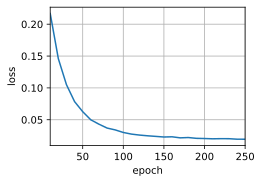

In [31]:
# 训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [33]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

NotImplementedError: 

In [34]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

NameError: name 'dec_attention_weight_seq' is not defined

In [ ]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## 自注意力## 和位置编码

* 给定序列$x_1, ..., x_n, \forall x_i \in R^d$
* 自注意力池化层将$x_i$当作key, value, query来对序列抽取特征得到$y_1, ..., y_n$，其中

$$
y_i = f(x_i, (x_1, x_1), ..., (x_n, x_x)) \in R^d
$$

![self attention](./imgs/self_attention.png)

### 跟CNN，RNN相比

![comparison](./imgs/self_attention_comparison.png)

|            | CNN        | RNN      | Self-Attention |
| ---------- | ---------- | -------- | -------------- |
| 计算读杂度 | O(k n d^2) | O(n d^2) | O(n^2d)        |
| 并行度     | O(n)       | O(1)     | O(n)           |
| 最长路径   | O(n / k)   | O(n)     | O(1)           |

### 位置编码

* 跟CNN/RNN不同，自注意力没有记录位置信息
* 位置编码将位置信息注入到输入里
  * 假设长度为n的序列是$X \in R^{n*d}$，那么使用位置编码矩阵$P \in R^{n*d}来输出X + P作为自编码输入
* P的元素计算：

$$
p_{i, 2j} = sin(\frac{i}{10000^{2j / d}})\\
p_{i, 2j + 1} = cos(\frac{i}{10000^{2j / d}})
$$

#### 位置编码矩阵
$$
P \in R^{n*d}:p_{i, 2j} = sin(\frac{i}{10000^{2j / d}}),
p_{i, 2j + 1} = cos(\frac{i}{10000^{2j / d}})
$$
![position encoding](./imgs/position_encoding.png)

#### 绝对位置信息


#### 相对位置信息

* 相对与$i + \delta$处的位置编码可以线性投影位置i处的位置编码来表示
* 记$w_j =1 / 10000^{2j/d}$，那么
$$
cos(\delta w_j) ~sin(\delta w_j)\\
-sin(\delta w_j) ~ cos(\delta w_j)
$$
$p_{i, 2j} \\ p_{i, 2j + 1}$
=
$p_{i+\delta, 2j} \\ p_{i+\delta, 2j + 1}$

投影矩阵跟i无关 

summary
* 自注意力池化层将$x_i$当作key, value, query来对序列抽取特征
* 完全并行，最长序列为1,但对长序列计算复杂度高
* 位置编码在输入中加入位置信息，使得自注意力能够记忆位置信息

### 代码


In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
# 位置编码
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens)) # 主要是生成一个位置编码矩阵P
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

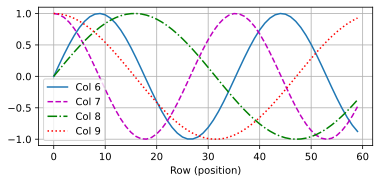

In [9]:
# 行代表标记在序列中的位置，列代表位置编码的不同维度

encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [10]:
# 绝对位置信息
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


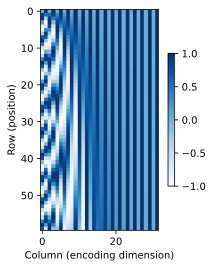

In [11]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

## Transformer

### Transformer架构
* 基于编码器——解码器架构来处理序列对
* 跟使用注意力的seq2seq不同，Transformer是纯基于注意力
![transformer](./imgs/transformer.png)

### 多头注意力Multi-Head Attention
* 对同一个key, value, query，希望抽取不同的信息
    * 例如短距离关系和长距离关系
* 多头注意力使用h个独立的注意力池化
    * 合并各个头(head)输出得到最终输出

![multi head transformer](./imgs/multi_head_attention.png)


#### MHA在数学上
* query $q \in R^{d_q}$, key $k \in R^{d_k}$, value $v \in R^{d_v}$
* 头i的可学习参数$W_i^{(q)} \in R^{p_q * d_q}, W_i^{(k)} \in R^{p_k * d_k}, W_i^{(v)} \in R^{p_v * d_v}$
* 头i的输出$h_i = f(W_i^{(q)}q, W_i^{(k)}k, W_i^{(v)}v)$
* 输出的科学习参数$W_o \in R^{p_o * hp_v}$
* 多头注意力的输出$W_o h^T \in R^{p_o}$


### 带掩码的多头注意力 masked multi-head attention
* 解码器对序列中的一个元素输出时，不应该考虑该元素之后的元素
* 可以通过掩码mask来实现
    * 也就是计算$x_i$输出时，假装当前序列长度为i


### 基于位置的前馈网络 positionwise FFN
* 将输入形状由(b, n, d)变换成(bn, d)
* 作用两个全连接层
* 输出形状由(bn, d)变化回(b, n, d)
* 等价于两层核窗口为1的一维卷积层

### 层归一化
* 批量归一化对每个特镇/通道里的元素进行归一化
    * 不适合序列长度会变的NLP应用
* 层归一化对每个样本里的元素进行归一化
![layer norm](./imgs/layer_norm.png)


### 信息传递
* 编码器中的输出$y_1, ..., y_n$
* 将其作为解码中第i个Transformer块中多头注意力的key和value
    * 它的query来自目标序列
* 意味着编码器和解码器中块的个数和输出维度都是一样的

### 预测
* 预测第t + 1个输出时
* 解码器中输入前t个预测值
    * 在自注意力中，前t个预测值作为key和value，第t个预测值还作为query


### 代码
#### 多头注意力

In [5]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
# 选择scaled dot-product attention作为每一个注意力头

def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])


def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    # permute 不会改变张量的形状或数据，只是重新排列维度的顺序。
    # 在图像处理、NLP 等任务中，当数据的维度顺序与操作不匹配时，可以用 permute 来调整。
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs) -> None:
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_q(keys), self.num_heads)
        values = transpose_qkv(self.W_q(values), self.num_heads)
        
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        output = self.attention(queries, keys, values, valid_lens)
        
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [8]:
# 测试

num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(
    num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_hiddens, 0.5)
attention.eval()
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

#### Transformer代码

In [4]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
# 基于位置的前馈网络

# 名字取得好，其实就是一个MLP
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, 
                 ffn_num_outputs, **kwargs) -> None:
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        
    def forward(self, X):
        return self.dense2(
            self.relu(
                self.dense1(X)
            )
        )    

In [6]:
# 改变张量的最里层维度的尺寸

ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.3235, -0.0148, -0.4469, -0.5605,  0.0713, -0.1908,  0.0225, -0.0472],
        [-0.3235, -0.0148, -0.4469, -0.5605,  0.0713, -0.1908,  0.0225, -0.0472],
        [-0.3235, -0.0148, -0.4469, -0.5605,  0.0713, -0.1908,  0.0225, -0.0472]],
       grad_fn=<SelectBackward0>)

In [7]:
# 对比不同为idu的层归一化和批量归一化效果

ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print(f'layer norm: {ln(X)}, \n batch norm: {bn(X)}')

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>), 
 batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [8]:
# 使用残差连接和层归一化

class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs) -> None:
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [9]:
# 加法操作后输出张量相同

add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [10]:
# 实现编码器中的一个层

class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs) -> None:
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, 
            num_heads, dropout, bias=use_bias
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [11]:
# transformer编码器中任何层都不会改变其输入的形状

X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [18]:
# Transformer编码器

class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
        
    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(
            self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [19]:
# 创建一个两层的Transformer编码器

encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [21]:
# Transformer解码器也是由多个相同的层组成


class DecoderBlock(nn.Module):
    '''解码器中第i个块'''
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs) -> None:
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout 
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout 
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1) 
        else:
            dec_valid_lens = None
        
        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [22]:
# 开始写解码器

class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, 
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_output, enc_valid_lens, *args):
        return [enc_output, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights
        

loss 0.032, 17755.0 tokens/sec on cpu


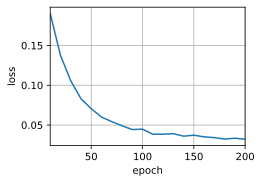

In [23]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [24]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


torch.Size([2, 4, 10, 10])


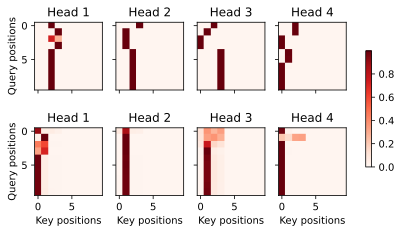

In [26]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
print(enc_attention_weights.shape)
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

torch.Size([2, 4, 6, 10]) torch.Size([2, 4, 6, 10])


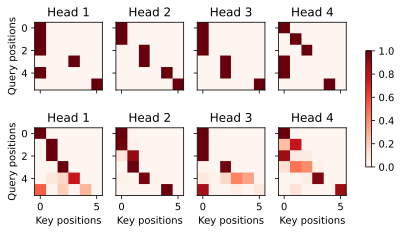

In [27]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
print(dec_self_attention_weights.shape, dec_inter_attention_weights.shape)

d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

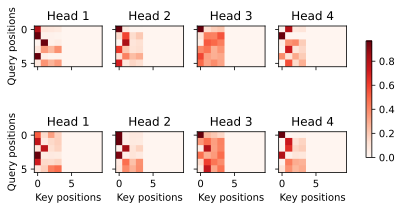

In [28]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

## BERT预训练

### NLP中的迁移学习
* 使用预训练好的模型来抽取词、句子的特征
    * 例如word2vec或语言模型
* 不更新与训练好的模型
* 需要构建新的网络来抓取新任务需要的信息    
    * Word2Vec忽略了时序信息，语言模型只看了一个方向


### BERT的动机
* 基于微调的NLP模型
* 预训练的模型抽取了足够多的信息
* 新的任务只需要增加一个简单的输出层
![NLP fine tuning](./imgs/fine_tuning_in_nlp.png)

### BERT架构
* 只有编码器的Transformer
* 两个版本
    * Base: #blocks = 12, hidden size = 768, #heads = 12, #parameters = 110M
    * Large: #blocks = 24, hidden size = 1024, #heads = 16, #parameters = 340M
* 在大规模数据上训练 > 3B词

### 一些创新
#### 对输入的修改
* 每个样本是一个句子对
* 加入额外的片段嵌入
* 位置编码可学习
![input reshaped](./imgs/input_reshape.png)

#### 预训练任务1：带掩码的语言模型
* Transformer的编码器是双向，标准语言模型要求单向
* 带掩码的语言模型每次随机(15%概率)将一些词元换成< mask >
* 因为微调任务中不出现< mask >
    * 80%概率下，将选中的词元变成< mask >
    * 10%换成一个随机词元
    * 10%保持原有词元

#### 预训练2：下一句子预测
* 预测一个句子对中两个句子是不是相邻
* 训练样本中：
    * 50%概率选择相邻句子对：
        < cls > this movie is great < sep > i like it < sep >
    * 50%概率选择随机句子对
        < cls > this movie is great < sep > hello world < sep >
* 将< cls >对应的输出放到一个全连接层来预测

### 代码：三部分
#### BERT代码

In [10]:
# Bidirectional Encoder Representaion from Transformers(BERT)

import torch
from torch import nn
from d2l import torch as d2l

In [11]:
# input representation

def get_tokens_and_segments(tokens_a, tokens_b=None):
    '''get tokens of the BERT input sequence and their segment IDs'''
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments


In [12]:
# BERTEncoder class

class BERTEncoder(nn.Module):
    '''BERT encoder'''
    def __init__(self, vocab_size, num_hiddens, norm_shape ,ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f'{i}', d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        self.pos_embedding = nn.Parameter(
            torch.randn(1, max_len, num_hiddens)) # 随机初始化，让他可学
        
    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [13]:
# inference
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)


# 试一下
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [20]:
# masked language modeling

class MaskLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs) -> None:
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.LayerNorm(num_hiddens),
            nn.Linear(num_hiddens, vocab_size)
        )
        
    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [21]:
# inference

mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [22]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

In [23]:
# next sentence prediction

class NextSentencePred(nn.Module):
    def __init__(self, num_inputs, **kwargs) -> None:
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)
    
    def forward(self, X):
        return self.output(X)

In [24]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输入形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [25]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

In [26]:
# 整合

class BERTModel(nn.Module):
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(
                vocab_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                dropout, max_len=max_len, key_size=key_size,
                query_size=query_size, value_size=value_size
            )
        self.hidden = nn.Sequential(
            nn.Linear(hid_in_features, num_hiddens),
            nn.Tanh()
        )
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 用于下一句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

#### 预先训练数据代码

In [28]:
import os
import random
import torch
from d2l import torch as d2l


#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [30]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs是三重列表的嵌套
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [31]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # 考虑1个'<cls>'词元和2个'<sep>'词元
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [32]:
#@save
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # 为遮蔽语言模型的输入创建新的词元副本，其中输入可能包含替换的“<mask>”或随机词元
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # 打乱后用于在遮蔽语言模型任务中获取15%的随机词元进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80%的时间：将词替换为“<mask>”词元
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%的时间：保持词不变
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10%的时间：用随机词替换该词
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [33]:
#@save
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # tokens是一个字符串列表
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 遮蔽语言模型任务中预测15%的随机词元
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [34]:
#@save
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # valid_lens不包括'<pad>'的计数
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [35]:
#@save
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # 输入paragraphs[i]是代表段落的句子字符串列表；
        # 而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下一句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # 获取遮蔽语言模型任务的数据
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # 填充输入
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [36]:
#@save
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [37]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

BadZipFile: File is not a zip file

In [38]:
len(vocab)

NameError: name 'vocab' is not defined

#### 预训练代码

a small BERT, using 2 layers, 128 hiddden units, and 2 self-attention heads

In [ ]:
net = d2l.BERTModel(
    len(vocab), num_hiddens=128, norm_shape=[128],
    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
    num_layers=2, dropout=0.2, key_size=128, query_size=128,
    value_size=128, hid_in_features=128, mlm_in_features=128,
    nsp_in_features=128
)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [2]:
# conpute the loss for both the masked language
# modeling and next sentence prediction tasks

def _get_batch_loss_bert(
    net, loss, vocab_size, tokens_X,
    segments_X, valid_lens_x,
    pred_positions_X, mlm_weights_X,
    mlm_Y, nsp_y
):
    _, mlm_Y_hat, nsp_Y_hat = net(
        tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X)
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1))
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l
    

In [4]:
# pretrain

def train_bert(
    train_iter, net, loss, vocab_size, devices, num_steps):
    net=nn.DataParallel(net, device_ids=devices).to(device[0]),
    trainer = torch.optim.Adam(net.parameters(), lr=1e-3)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(
        xlabel='step', ylabel='loss', 
        xlim=[1, num_epochs], legend=['mlm', 'nsp']
    )
    metric =d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_X, pred_positions_X, \
            mlm_weights_X, mlm_Y, nsp_Y in train_iter:
            
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
        print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
        print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')
            
train_bert(train_iter, net, loss, len(vocab), devices, 50)



NameError: name 'train_iter' is not defined

In [ ]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [ ]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

## BERT微调

开始fine-tuning

### 微调BERT
* BERT对每一个词元返回抽取了上下文信息的特征向量
* 不同的任务使用不同的特性

![fine tuning in BERT](./imgs/bert_fine_tuning.png)

### 句子分类
* 将< cls >对应的向量输入到全连接层分类


### 实体命名识别
* 识别一个词元是不是命名实体，例如人名、机构、设置
* 将非特殊词元放进全连接层分类

### 问题回答
* 给定一个问题，和描述文字，找出一个片段作为回答
* 对片段中的每个词元预测是不是回答的开头或结束


summary
* 即使下游任务各有不同，使用BERT微调时均只需要增加输出层
* 但根据任务的不同，输入的表示，和使用的BERT特征也会不一样


### instance: natural language inference and the datasets


In [14]:
import os
import re
import torch
import json
import multiprocessing
from torch import nn
from d2l import torch as d2l


In [16]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    # data_dir = d2l.download_extract(pretrained_model)
    data_dir = os.path.join('../data', 'bert.small.torch')
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [17]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [18]:
# 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
# data_dir = d2l.download_extract('SNLI')
data_dir = os.path.join('../data', 'snli_1.0')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples
read 9824 examples


In [19]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))
    
net = BERTClassifier(bert)

KeyboardInterrupt: 

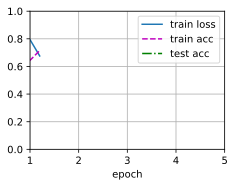

In [20]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 优化算法

## 优化算法
### 优化问题
* 一般形式
$$
min~ f(x)~~subject~to~x \in C
$$
* 目标函数$f: R^n \rightarrow R$
* 限制集合例子
* 如果$C = R^n$那就是不受限

### 局部最小 vs 全局最小
* 使用迭代优化算法求解，一般只能保证找到局部最小值

### 凸
#### 凸集
* 任意凸集中两点连接线段均在这个集合中

#### 凸函数
* 一般指的是下凸

#### 凸函数优化
* 局部最小一定是全局最小
* 严格凸优化问题有唯一的全局最小

#### 例子
* 凸
    * 线性回归
    * Softmax回归
* 非凸：其他
    * MLP、CNN、RNN、attention、...


### 梯度下降
* 选取开始点$x_0$
* 对t = 1, 2, ..., T
    * $x_t = x_{t - 1} - \eta \nabla f(x_{t - 1})$
    * $\eta$ 为learning rate学习率

### 随机梯度下降
* 有n个样本时，计算$f(x) = \frac{1}{n} l_i(x)$的导数太贵
* 随机梯度下降在时间t随机选项样本$t_i$来近似$f(x)$
$$
x_t = t_{t - 1} - \eta_t \nabla l_{t_i}(X_{t - 1})\\
E[\nabla l_{t_i}(x)] = E[\nabla f(x)]
$$

### 小批量随机梯度下降
* 计算单样本的梯度南完全利用硬件资源
* 小批量随机梯度下降在时间t采样一个随机子集$I_t \in {1, 2, ..., n}$使得 $|I_t| = b$
$$
x_t = x_{t - 1} - \frac{\eta_t}{b} \Sigma_{i \in I_t} \nabla l_i(x_{t-1})
$$
* 这是一个无偏的近似，但降低了方差
$$
E[\frac{1}{b} \Sigma_{i \in I_t} \nabla l_i (x)] = \nabla f(x)
$$

### 冲量法momentum
* 使用平滑过的梯度对权重更新
$$
g_t = \frac{1}{b} \Sigma_{i \in I_t} \nabla l_i (x_{t-1})\\
v_t = \beta v_{t - 1} + g_t, w_t = w_{t-1} - \eta v_t
$$
梯度平滑: $v_t = g_t + \beta g_{t-1} + \beta^2 g_{t-2} + ... $
* $\beta 常见取值 [0.5, 0.9, 0.95, 0.99]$

### Adam 
* 记录$v_t = \beta_1 v_{t -1} + (1 - \beta_1) g_t, \beta_1 = 0.9~often$
* 展开$ v_t = (1 - \beta_1)(g_t + \beta_1 g_{t - 1} + \beta_1^2 g_{t - 2} + ...) $
* 权重和为1
* 由于$v_0 = 0$，且$\Sigma_{i=0}^t \beta_1^t = \frac{1 - \beta_1^t}{1 - \beta_1} $，修正$\hat{v}_t = \frac{v_t}{1 - \beta_1^t}$



* 类似记录$s_t = \beta_2 s_{t-1} = (1 - \beta_2)g_t^2, \beta_2 = 0.999~often$，且修正$\hat{s}_t = \frac{s_t}{1 - \beta_2^t}$
* 计算重新调整后的梯度$g'_t = \frac{\hat{v}_t}{\sqrt{\hat{s}_t} + \epsilon}$
* 最后更新$w_t = w_{t-1} - \eta g_t'$ 

## 学会读论文
* 经典论文需要读懂每一句话
* 结合代码看论文
* 看openreview上的评论